# Caracterization

This notebook contains analysis on the graph of Movie Lens 1M dataset. We consider this dataset to be a directed bipartite graph where nodes are users and items, with edges going from users to items and the edge-weights being the users' ratings. 

In [3]:
import os, sys
import networkx as nx
from powerlaw import ccdf
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

In [4]:
data_folder = os.path.join('..', 'Data', 'ML1M')
images_folder = os.path.join('.', 'Images')
variables_folder = os.path.join('.', 'Variables')

## Loading the Dataset

In [6]:
dataset_tag, dataset_file = "ML1M", os.path.join(data_folder, 'ratings.dat')
# dict_metrics[dataset_tag] = dict()
# dict_plots[dataset_tag] = dict()
df = pd.read_csv(dataset_file, header=None, sep=r'::', engine="python")
df.columns = ["from", "to", "rating", "timestamp"]
df['from'] = df['from'].apply(lambda x: 'user_' + str(x))
df['to'] = df['to'].apply(lambda x: 'item_' + str(x))
# My job starts here ! ;D
# df.drop(["timestamp"], axis=1, inplace=True)
df.to_csv(os.path.join(variables_folder, dataset_tag + "_edgelist.txt"), sep='\t', index=False, header=None)
df.head()

,from,to,rating,timestamp
0,user_1,item_1193,5,978300760
1,user_1,item_661,3,978302109
2,user_1,item_914,3,978301968
3,user_1,item_3408,4,978300275
4,user_1,item_2355,5,978824291


## Processing Time

In [31]:
import time
time_sorted = df.sort_values(by=['timestamp'], ascending=False)

In [33]:
print('Max time: ', 
          time.strftime("%D %H:%M", time.localtime(int(time_sorted['timestamp'].max()))), 
      'and Min time: ', 
          time.strftime("%D %H:%M", time.localtime(int(time_sorted['timestamp'].min()))) )

Max time:  02/28/03 14:49 and Min time:  04/25/00 20:05


In [93]:
time_sorted['datetime'] = pd.to_datetime(time_sorted['timestamp'].astype(int), unit='s')
time_sorted_index = time_sorted.set_index(pd.DatetimeIndex(time_sorted['datetime']))

In [94]:
time_sorted_index[(time_sorted_index['datetime'] > '2003-02-27')].head()

,from,to,rating,timestamp,datetime
datetime,,,,,
2003-02-28 17:49:50,user_4958,item_1924,4,1046454590,2003-02-28 17:49:50
2003-02-28 17:49:08,user_4958,item_3264,4,1046454548,2003-02-28 17:49:08
2003-02-28 17:49:08,user_4958,item_2634,3,1046454548,2003-02-28 17:49:08
2003-02-28 17:47:23,user_4958,item_1407,5,1046454443,2003-02-28 17:47:23
2003-02-28 17:45:38,user_4958,item_2399,1,1046454338,2003-02-28 17:45:38


### Splitting by Time

In [185]:
# Define a type : year ; month ; week ; day ( would be nice to only see weekends jão ? ) 
# And split your dataset evenly by that amount
## Fun fact: There are somedays that have WAY more data than some. this WILL impact the prediction. Maybe normalize the rating. for example.
def dataset_time_splitter(param_timedf, splitting_strategy = None):
    if param_timedf is None or splitting_strategy is None:
        return
    
    # Year 2003 is just 2 months so ignored it.
    if splitting_strategy == "year":
        df_time_return_1 = param_timedf[param_timedf.index.year.isin([2002,2003])]
        df_time_return_2 = param_timedf[param_timedf.index.year.isin([2001])]
        df_time_return_3 = param_timedf[param_timedf.index.year.isin([2000])]
        return [df_time_return_1, df_time_return_2 , df_time_return_3]
    if splitting_strategy == "month":
        lista_dfs_months = []
        for x in range(1, 13):
            lista_dfs_months.append(param_timedf[param_timedf.index.month.isin([x])])
        return lista_dfs_months
    # around 50 weeks each year, total of 156
    if splitting_strategy == "week":
        lista_dfs_weeks  = []
        for y in range (2000, 2003):
            for x in range(1, (max(time_sorted_index.index.week)+1)):
                lista_dfs_weeks.append(param_timedf[param_timedf.index.week.isin([x]) & param_timedf.index.year.isin([y])])
        return lista_dfs_weeks
    # around 365 weeks each year, total of 1096
    if splitting_strategy == "day":
        lista_dfs_days  = []
        for y in range (2000, 2003):
            for x in range(1, (max(time_sorted_index[time_sorted_index.index.year.isin([y])].index.dayofyear)+1)):
                lista_dfs_days.append(param_timedf[param_timedf.index.dayofyear.isin([x]) & param_timedf.index.year.isin([y])])
        return lista_dfs_days

In [192]:
lista = dataset_time_splitter(time_sorted_index,"year")

In [193]:
len(lista)

3

## Creating Network

In [199]:
def build_list_of_networks(param_list):
    graph_list = []
    G = nx.DiGraph()
    for df_graph in param_list:
        for user_id in df_graph["from"].unique():
            G.add_node(user_id, node_type="user")
        for item_id in df_graph["to"].unique():
            G.add_node(item_id, node_type="item")
        G.add_weighted_edges_from(df_graph[["from", "to", "rating"]].values)
        graph_list.append(G)
    return graph_list

In [196]:
graph_list = build_list_of_networks(lista)

In [204]:
def print_specs_for_graphs(param_list_graph):
    for G in param_list_graph:
        print("*****************************************")
        print ("Number of edges: ", G.number_of_edges())
        print ("Number of nodes: ", G.number_of_nodes())
#         for node_type in ["user", "item"]:
#             n_type_nodes = G.subgraph([n for n,attrdict in G.node.items() if attrdict['node_type'] == node_type] ).number_of_nodes()
#             print ("Number of " + node_type + " nodes: ", n_type_nodes)
        print ("Is strongly connected: ", nx.is_strongly_connected(G))
        print ("Number of strongly connected components: ", nx.number_strongly_connected_components(G))
        print("*****************************************")

In [205]:
print_specs_for_graphs(graph_list)

*****************************************
Number of edges:  1000209
Number of nodes:  9746
Is strongly connected:  False
Number of strongly connected components:  9746
*****************************************
*****************************************
Number of edges:  1000209
Number of nodes:  9746
Is strongly connected:  False
Number of strongly connected components:  9746
*****************************************
*****************************************
Number of edges:  1000209
Number of nodes:  9746
Is strongly connected:  False
Number of strongly connected components:  9746
*****************************************


In [ ]:
## Proximos passos : Adicionar mais estatisticas e observar a variacao no ano.

## Getting Statistics
### Degree

In [16]:
df_stats = pd.DataFrame(nx.degree(G))
df_stats.columns = ['node', 'degree']
df_stats['degree_centrality'] = nx.degree_centrality(G).values()
# dict_metrics[dataset_tag]["degree"] = np.array(df_stats["degree"])
df_stats.tail()

,node,degree,degree_centrality
9741,item_2198,2,0.000205
9742,item_2703,1,0.000103
9743,item_2845,1,0.000103
9744,item_3607,1,0.000103
9745,item_2909,1,0.000103


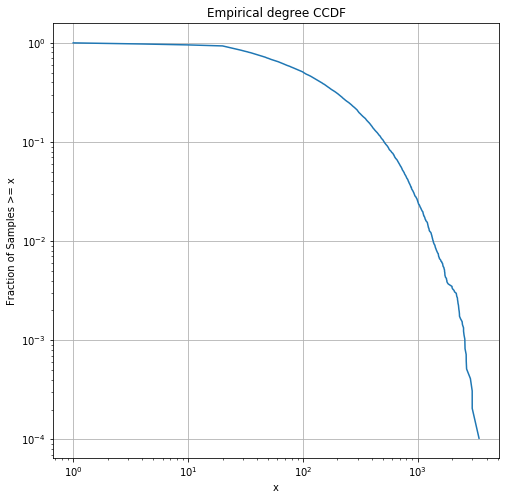

In [108]:
def plot_ccdf(samples, name=''):
    x, y = ccdf(samples)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax.set_title("Empirical " + name + " CCDF")
    ax.plot(x, y)
    ax.set_xscale("log"), ax.set_yscale("log")
    ax.set_xlabel("x"), ax.set_ylabel("Fraction of Samples >= x")
    ax.grid(True)
    return fig, ax 

fig, ax = plot_ccdf(df_stats["degree"], "degree")

## Saving degree to trainable dataset

In [27]:
df_degrees = pd.merge(df, df_stats, how='inner', left_on='from', right_on='node').drop(['node'], axis=1)
df_degrees = pd.merge(df_degrees, df_stats, how='inner', left_on='to', right_on='node', 
                   suffixes=['_user', '_item']).drop(['node'], axis=1)
df_degrees

,from,to,rating,degree_user,degree_centrality_user,degree_item,degree_centrality_item
0,user_1,item_1193,5,53,0.005439,1725,0.177014
1,user_2,item_1193,5,129,0.013238,1725,0.177014
2,user_12,item_1193,4,23,0.002360,1725,0.177014
3,user_15,item_1193,4,201,0.020626,1725,0.177014
4,user_17,item_1193,5,211,0.021652,1725,0.177014
...,...,...,...,...,...,...,...
1000204,user_5949,item_2198,5,181,0.018574,2,0.000205
1000205,user_5675,item_2703,3,586,0.060133,1,0.000103
1000206,user_5780,item_2845,1,259,0.026578,1,0.000103
1000207,user_5851,item_3607,5,162,0.016624,1,0.000103


In [28]:
df_degrees.to_csv(os.path.join(variables_folder, 'df_degrees.csv'), sep=';', index=None)

## Studying Threshold Variations

How the number of users or items vary when we make degree centrality thresholds ?

In [73]:
# Sets an array with the applied thresholds to be made
step_size = 2
degree_thr = [x/100 for x in np.arange(0, 101, step_size)]

### Getting Threshold Variations

We have 2 strategies here: 

- `upper`: only users/items with **higher** degree centrality than the threshold are allowed in the results dataset
- `lower`: only users/items with **lower** degree centrality than the threshold are allowed in the results dataset 

In [106]:
%%time
n_users_thr, n_items_thr = [], []
user_degree_thr, item_degree_thr = [], []
n_users_max = len(df_degrees['from'].unique())
n_items_max = len(df_degrees['to'].unique())
strategy = 'upper' # upper, lower
for threshold in degree_thr:    
    if strategy == 'upper':
        df_temp = df_degrees[df_degrees['degree_centrality_user'] > threshold]
    else:
        df_temp = df_degrees[df_degrees['degree_centrality_user'] < threshold]        
    n_users = len(df_temp['from'].unique())    
    n_users_thr.append(n_users)
    user_degree_thr.append(threshold)
    if n_users == 0 and strategy == 'upper':
        break
    if n_users == n_users_max and strategy == 'lower':
        break  
        
for threshold in degree_thr:    
    if strategy == 'upper':
        df_temp = df_degrees[df_degrees['degree_centrality_item'] > threshold]
    else:
        df_temp = df_degrees[df_degrees['degree_centrality_item'] < threshold]        
    n_items = len(df_temp['to'].unique())    
    n_items_thr.append(n_items)
    item_degree_thr.append(threshold)
    if n_items == 0 and strategy == 'upper':
        break
    if n_items == n_items_max and strategy == 'lower':
        break  
        
df_temp.head()

Wall time: 2.36 s


[Text(0, 0.5, 'Quantity'), Text(0, 0.5, 'Quantity')]

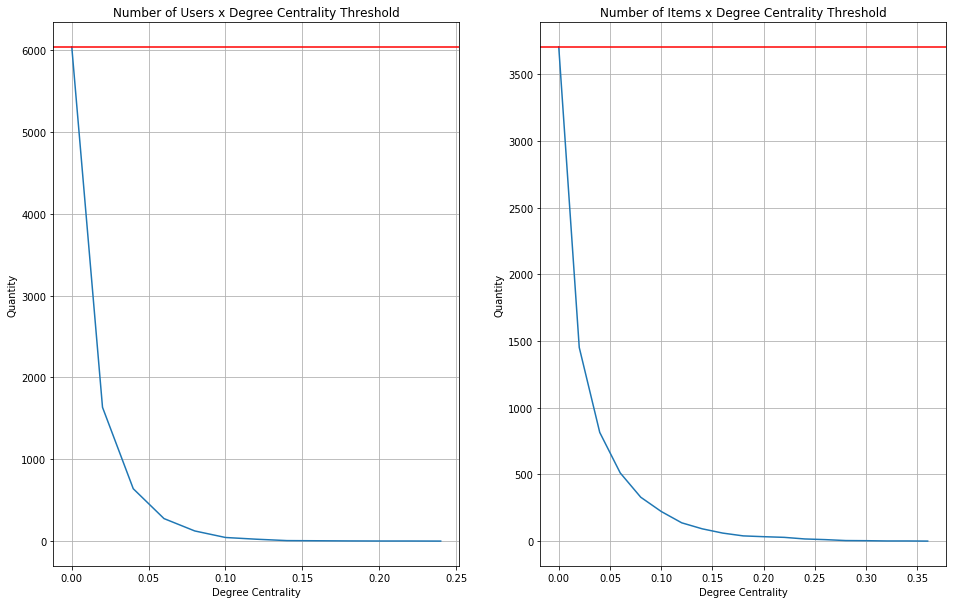

In [107]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
axes[0].plot(user_degree_thr, n_users_thr)
axes[0].axhline(n_users_max, color='r')
axes[0].set_title('Number of Users x Degree Centrality Threshold')

axes[1].plot(item_degree_thr, n_items_thr)
axes[1].axhline(n_items_max, color='r')
axes[1].set_title('Number of Items x Degree Centrality Threshold')

[ax.grid(True) for ax in axes]
[ax.set_xlabel('Degree Centrality') for ax in axes]
[ax.set_ylabel('Quantity') for ax in axes]